In [6]:
# Install dependencies (run once)
# !pip install rasterio numpy matplotlib scipy pdal python-pdal

import rasterio
from rasterio.windows import from_bounds
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Data URLs
dem_url = "https://stac.uixai.org/data/fujisan_dem_2024_official_jgd.cog.tif"
copc_url = "https://stac.uixai.org/data/fujisan-unified.copc.laz"

print(f"DEM: {dem_url}")
print(f"COPC: {copc_url}")
print("CRS: EPSG:6676 (JGD2011 Zone 8)")

DEM: https://stac.uixai.org/data/fujisan_dem_2024_official_jgd.cog.tif
COPC: https://stac.uixai.org/data/fujisan-unified.copc.laz
CRS: EPSG:6676 (JGD2011 Zone 8)


In [7]:
# Define analysis area (1km x 1km)
analysis_area = {
    "west": 20000, "east": 21000,
    "south": -70000, "north": -69000
}

with rasterio.open(dem_url) as src:
    print("=== DEM Info ===")
    print(f"CRS: {src.crs}")
    print(f"Resolution: {src.res[0]:.2f} m")
    
    window = from_bounds(
        analysis_area["west"], analysis_area["south"],
        analysis_area["east"], analysis_area["north"],
        src.transform
    )
    dem = src.read(1, window=window)
    resolution = src.res[0]
    
    # Handle NoData
    if src.nodata is not None:
        dem = np.ma.masked_equal(dem, src.nodata)
    dem = np.ma.masked_outside(dem, 500, 4000)
    
    print(f"Area: {analysis_area['east']-analysis_area['west']}m x {analysis_area['north']-analysis_area['south']}m")
    print(f"Elevation range: {float(dem.min()):.1f} - {float(dem.max()):.1f} m")

=== DEM Info ===
CRS: EPSG:6676
Resolution: 0.50 m
Area: 1000m x 1000m
Elevation range: 2816.4 - 3647.8 m


In [9]:
# Calculate slope (degrees)
dem_filled = np.ma.filled(dem, np.nan)
dy, dx = np.gradient(dem_filled, resolution)
slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
slope_deg = np.degrees(slope_rad)

# Earthquake-induced landslide risk classification
# Based on Japanese Building Standards Law
risk_low = slope_deg < 15
risk_medium = (slope_deg >= 15) & (slope_deg < 30)
risk_high = (slope_deg >= 30) & (slope_deg < 45)
risk_critical = slope_deg >= 45

# Calculate areas (m²)
pixel_area = resolution ** 2

print("=== Slope Stability Analysis ===")
print("(Based on Japanese seismic standards)")
print(f"\nLow Risk (<15°):      {np.nansum(risk_low) * pixel_area / 10000:.2f} ha")
print(f"Medium Risk (15-30°): {np.nansum(risk_medium) * pixel_area / 10000:.2f} ha")
print(f"High Risk (30-45°):   {np.nansum(risk_high) * pixel_area / 10000:.2f} ha")
print(f"Critical (>45°):      {np.nansum(risk_critical) * pixel_area / 10000:.2f} ha")

# Percentage
total_valid = np.sum(~np.isnan(slope_deg))
print(f"\n=== Risk Distribution ===")
print(f"Low Risk:      {np.nansum(risk_low) / total_valid * 100:.1f}%")
print(f"Medium Risk:   {np.nansum(risk_medium) / total_valid * 100:.1f}%")
print(f"High Risk:     {np.nansum(risk_high) / total_valid * 100:.1f}%")
print(f"Critical:      {np.nansum(risk_critical) / total_valid * 100:.1f}%")

=== Slope Stability Analysis ===
(Based on Japanese seismic standards)

Low Risk (<15°):      0.19 ha
Medium Risk (15-30°): 32.66 ha
High Risk (30-45°):   60.77 ha
Critical (>45°):      6.38 ha

=== Risk Distribution ===
Low Risk:      0.2%
Medium Risk:   32.7%
High Risk:     60.8%
Critical:      6.4%


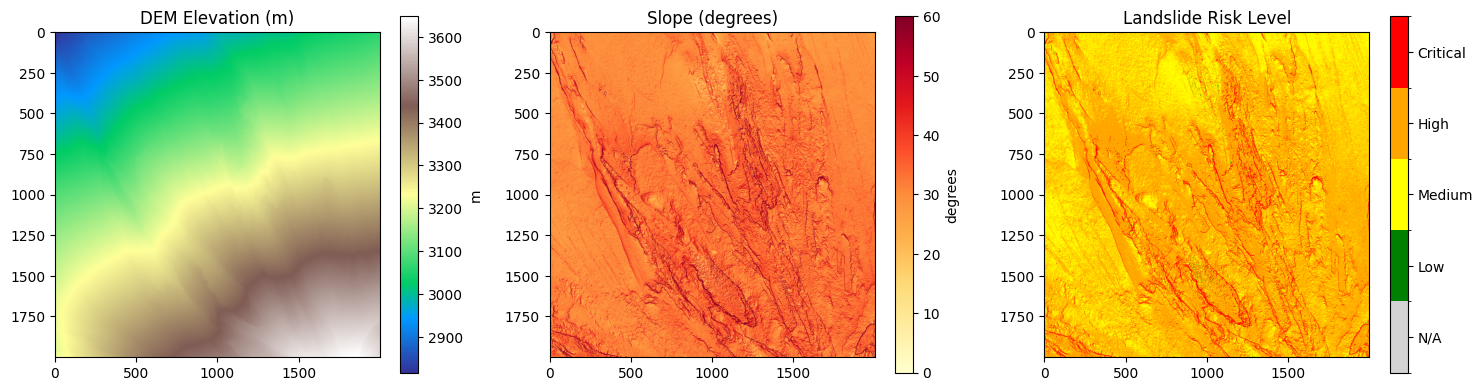

Saved: slope_stability.png


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original DEM
im1 = axes[0].imshow(dem, cmap='terrain')
axes[0].set_title('DEM Elevation (m)')
plt.colorbar(im1, ax=axes[0], label='m')

# Slope map
im2 = axes[1].imshow(slope_deg, cmap='YlOrRd', vmin=0, vmax=60)
axes[1].set_title('Slope (degrees)')
plt.colorbar(im2, ax=axes[1], label='degrees')

# Risk classification map
risk_map = np.zeros_like(slope_deg)
risk_map[risk_low] = 1
risk_map[risk_medium] = 2
risk_map[risk_high] = 3
risk_map[risk_critical] = 4
risk_map[np.isnan(slope_deg)] = 0

from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['lightgray', 'green', 'yellow', 'orange', 'red']
cmap_risk = ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap_risk.N)

im3 = axes[2].imshow(risk_map, cmap=cmap_risk, norm=norm)
axes[2].set_title('Landslide Risk Level')

# Create colorbar with correct number of ticks
cbar = plt.colorbar(im3, ax=axes[2], ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
cbar.set_ticklabels(['N/A', 'Low', 'Medium', 'High', 'Critical'])

plt.tight_layout()
plt.savefig('slope_stability.png', dpi=150)
plt.show()
print("Saved: slope_stability.png")

In [12]:
# Simplified site amplification based on slope and elevation
# Higher slopes and ridges tend to amplify seismic waves

# Calculate curvature (convex = ridge, concave = valley)
curvature = ndimage.laplace(dem_filled)

# Normalize to amplification factor (1.0 - 2.0)
# Ridges (positive curvature) = higher amplification
curvature_norm = np.clip(curvature, -0.1, 0.1)
amplification = 1.0 + (curvature_norm + 0.1) / 0.2 * 0.5

# Slope effect: steeper slopes = higher amplification
slope_factor = 1.0 + np.clip(slope_deg / 60, 0, 0.5)

# Combined amplification
total_amplification = amplification * slope_factor

print("=== Seismic Amplification Analysis ===")
print(f"Min amplification: {np.nanmin(total_amplification):.2f}x")
print(f"Max amplification: {np.nanmax(total_amplification):.2f}x")
print(f"Mean amplification: {np.nanmean(total_amplification):.2f}x")

# High amplification areas (>1.5x)
high_amp_area = np.nansum(total_amplification > 1.5) * pixel_area / 10000
print(f"\nHigh amplification areas (>1.5x): {high_amp_area:.2f} ha")

=== Seismic Amplification Analysis ===
Min amplification: 1.00x
Max amplification: 2.25x
Mean amplification: 1.86x

High amplification areas (>1.5x): 75.40 ha


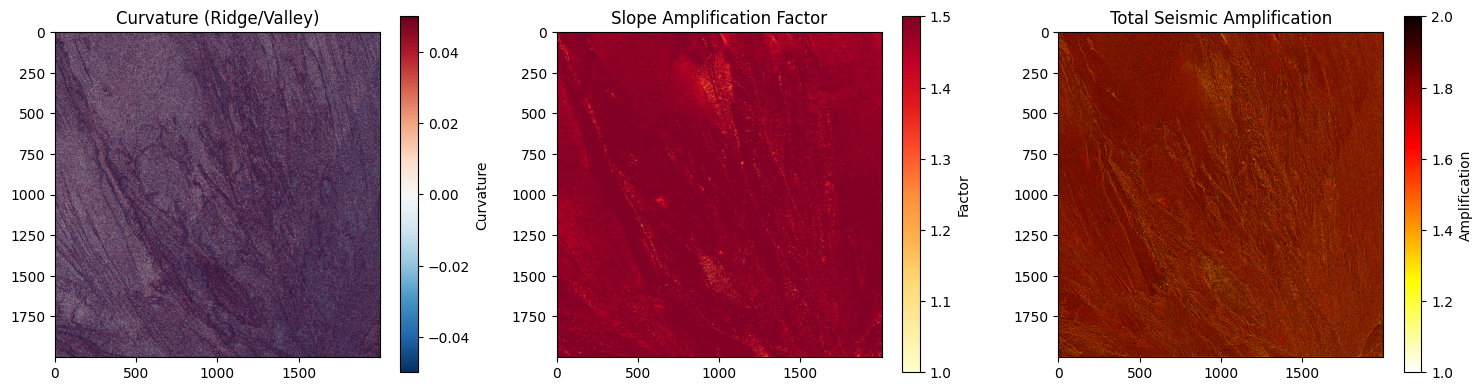

Saved: seismic_amplification.png


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Curvature (topographic position)
im1 = axes[0].imshow(curvature, cmap='RdBu_r', vmin=-0.05, vmax=0.05)
axes[0].set_title('Curvature (Ridge/Valley)')
plt.colorbar(im1, ax=axes[0], label='Curvature')

# Slope factor
im2 = axes[1].imshow(slope_factor, cmap='YlOrRd', vmin=1.0, vmax=1.5)
axes[1].set_title('Slope Amplification Factor')
plt.colorbar(im2, ax=axes[1], label='Factor')

# Total amplification
im3 = axes[2].imshow(total_amplification, cmap='hot_r', vmin=1.0, vmax=2.0)
axes[2].set_title('Total Seismic Amplification')
plt.colorbar(im3, ax=axes[2], label='Amplification')

plt.tight_layout()
plt.savefig('seismic_amplification.png', dpi=150)
plt.show()
print("Saved: seismic_amplification.png")

In [14]:
import pdal
import json

# Define area for building extraction
building_area = {
    "min_x": 20000, "max_x": 20500,
    "min_y": -69500, "max_y": -69000
}

# Extract all points first (COPC may not have building classification)
pipeline = {
    "pipeline": [
        {
            "type": "readers.copc",
            "filename": copc_url,
            "bounds": f"([{building_area['min_x']}, {building_area['max_x']}], [{building_area['min_y']}, {building_area['max_y']}])"
        }
    ]
}

print("Extracting points from COPC...")
p = pdal.Pipeline(json.dumps(pipeline))
count = p.execute()
points = p.arrays[0]

print(f"\n=== Point Cloud Data ===")
print(f"Total points: {len(points):,}")
print(f"X range: {points['X'].min():.1f} - {points['X'].max():.1f} m")
print(f"Y range: {points['Y'].min():.1f} - {points['Y'].max():.1f} m")
print(f"Z range: {points['Z'].min():.1f} - {points['Z'].max():.1f} m")

# Check available classifications
if 'Classification' in points.dtype.names:
    unique_classes = np.unique(points['Classification'])
    print(f"\nClassification codes: {unique_classes}")

Extracting points from COPC...

=== Point Cloud Data ===
Total points: 10,459,790
X range: 20000.0 - 20500.0 m
Y range: -69500.0 - -69000.0 m
Z range: 2816.3 - 3244.0 m

Classification codes: [1 2]


In [15]:
# Analyze point heights relative to minimum (approximate ground)
z_values = points['Z']
z_min = np.percentile(z_values, 5)  # Approximate ground level
relative_height = z_values - z_min

# Height distribution
print("=== Height Distribution ===")
print(f"Ground level (approx): {z_min:.1f} m")
print(f"Max height above ground: {relative_height.max():.1f} m")

# Count points at different heights
height_bins = [0, 2, 5, 10, 20, 50, 100]
for i in range(len(height_bins) - 1):
    count = np.sum((relative_height >= height_bins[i]) & (relative_height < height_bins[i+1]))
    pct = count / len(relative_height) * 100
    print(f"  {height_bins[i]:3d}-{height_bins[i+1]:3d}m: {count:8,} points ({pct:.1f}%)")

# Points above 10m might indicate buildings or tall structures
elevated_points = np.sum(relative_height > 10)
print(f"\nElevated points (>10m): {elevated_points:,} ({elevated_points/len(points)*100:.2f}%)")


=== Height Distribution ===
Ground level (approx): 2887.5 m
Max height above ground: 356.5 m
    0-  2m:   36,244 points (0.3%)
    2-  5m:   58,209 points (0.6%)
    5- 10m:  104,069 points (1.0%)
   10- 20m:  231,480 points (2.2%)
   20- 50m:  845,481 points (8.1%)
   50-100m: 1,985,644 points (19.0%)

Elevated points (>10m): 9,738,167 (93.10%)


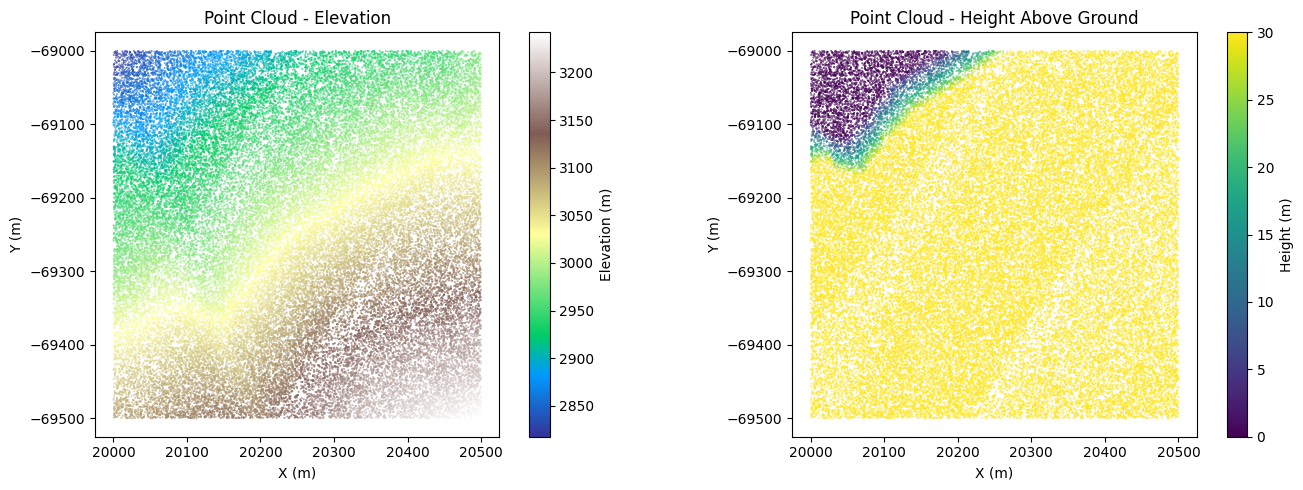

Saved: point_cloud_analysis.png


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sample points for visualization (max 50000)
sample_size = min(50000, len(points))
indices = np.random.choice(len(points), sample_size, replace=False)

x_sample = points['X'][indices]
y_sample = points['Y'][indices]
z_sample = points['Z'][indices]
h_sample = relative_height[indices]

# Top-down view colored by elevation
sc1 = axes[0].scatter(x_sample, y_sample, c=z_sample, s=0.1, cmap='terrain')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_title('Point Cloud - Elevation')
axes[0].set_aspect('equal')
plt.colorbar(sc1, ax=axes[0], label='Elevation (m)')

# Top-down view colored by height above ground
sc2 = axes[1].scatter(x_sample, y_sample, c=h_sample, s=0.1, cmap='viridis', vmin=0, vmax=30)
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].set_title('Point Cloud - Height Above Ground')
axes[1].set_aspect('equal')
plt.colorbar(sc2, ax=axes[1], label='Height (m)')

plt.tight_layout()
plt.savefig('point_cloud_analysis.png', dpi=150)
plt.show()
print("Saved: point_cloud_analysis.png")

In [17]:
print("=" * 60)
print("EARTHQUAKE SIMULATION REPORT")
print("Fujisan Area - EPSG:6676 (JGD2011 Zone 8)")
print("=" * 60)

print(f"\n[1] ANALYSIS AREA")
print(f"    Location: X={analysis_area['west']}-{analysis_area['east']}, Y={analysis_area['south']}-{analysis_area['north']}")
print(f"    Size: 1 km x 1 km")
print(f"    Resolution: {resolution} m")

print(f"\n[2] SLOPE STABILITY")
print(f"    Low Risk (<15°):      {np.nansum(risk_low) / total_valid * 100:.1f}%")
print(f"    Medium Risk (15-30°): {np.nansum(risk_medium) / total_valid * 100:.1f}%")
print(f"    High Risk (30-45°):   {np.nansum(risk_high) / total_valid * 100:.1f}%")
print(f"    Critical (>45°):      {np.nansum(risk_critical) / total_valid * 100:.1f}%")

print(f"\n[3] SEISMIC AMPLIFICATION")
print(f"    Mean: {np.nanmean(total_amplification):.2f}x")
print(f"    Max:  {np.nanmax(total_amplification):.2f}x")
print(f"    High-risk areas (>1.5x): {high_amp_area:.2f} ha")

print(f"\n[4] POINT CLOUD ANALYSIS")
print(f"    Total points: {len(points):,}")
print(f"    Elevated structures (>10m): {elevated_points:,} points")

print("\n" + "=" * 60)
print("Analysis complete!")
print("Generated files: slope_stability.png, seismic_amplification.png, point_cloud_analysis.png")

EARTHQUAKE SIMULATION REPORT
Fujisan Area - EPSG:6676 (JGD2011 Zone 8)

[1] ANALYSIS AREA
    Location: X=20000-21000, Y=-70000--69000
    Size: 1 km x 1 km
    Resolution: 0.5 m

[2] SLOPE STABILITY
    Low Risk (<15°):      0.2%
    Medium Risk (15-30°): 32.7%
    High Risk (30-45°):   60.8%
    Critical (>45°):      6.4%

[3] SEISMIC AMPLIFICATION
    Mean: 1.86x
    Max:  2.25x
    High-risk areas (>1.5x): 75.40 ha

[4] POINT CLOUD ANALYSIS
    Total points: 10,459,790
    Elevated structures (>10m): 9,738,167 points

Analysis complete!
Generated files: slope_stability.png, seismic_amplification.png, point_cloud_analysis.png
